Best transformation vector: [0.94068511 4.42417162 2.74591714]
Best loss: 2.063328481392026e-09


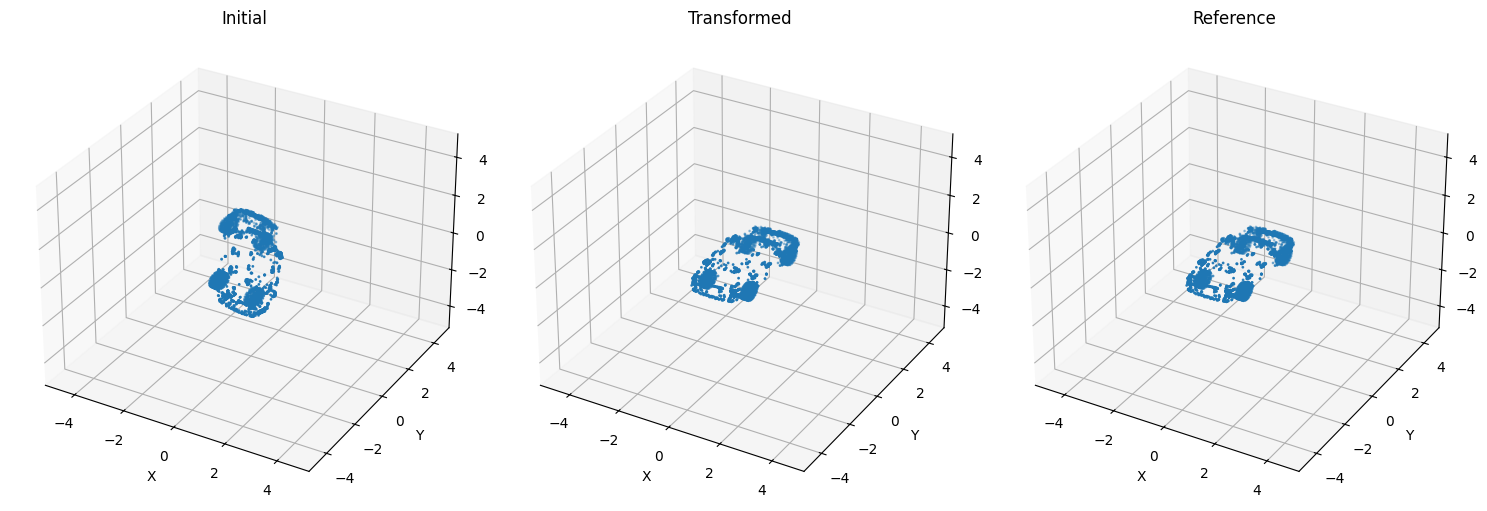

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import sys
sys.path.append('/workspace/utils')
from utils3d_model import load_point_clouds, display_point_clouds
from optimization_utils import build_transformation_matrix, objective_function_rotation, transform_point_cloud_numpy


# Visualize point clouds
def display_point_clouds(point_clouds, titles, num_cols=3):
    num_clouds = len(point_clouds)
    num_rows = (num_clouds + num_cols - 1) // num_cols
    fig = plt.figure(figsize=(num_cols * 5, num_rows * 5))

    for i, pc in enumerate(point_clouds):
        ax = fig.add_subplot(num_rows, num_cols, i + 1, projection='3d')
        ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=1)
        ax.set_title(titles[i])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 5])
        ax.set_zlim([-5, 5])

    plt.tight_layout()
    plt.show()

# Main execution block
folder_path = '/workspace/datasets/apollo/car_models_json'
files = os.listdir(folder_path)

point_clouds, titles = load_point_clouds(folder_path, files, len(files))
initial_pc = point_clouds["SUV"][0]  # Assuming first point cloud as the initial
reference_pc = initial_pc.copy()

# Apply random rotation to the initial point cloud
random_rotation = np.random.rand(3) * 2 * np.pi
initial_pc = transform_point_cloud_numpy(initial_pc, build_transformation_matrix(random_rotation, np.zeros(3)))

# Optimize rotation
best_transformation, best_loss = optimize_alignment(initial_pc, reference_pc)
print("Best transformation vector:", best_transformation)
print("Best loss:", best_loss)

# Apply transformation and visualize results
transformed_pc = transform_point_cloud_numpy(initial_pc, build_transformation_matrix(best_transformation, np.zeros(3)))  # No translation for simplicity
display_point_clouds([initial_pc, transformed_pc, reference_pc], ['Initial', 'Transformed', 'Reference'])


In [12]:
from scipy.spatial import ConvexHull

# Function to calculate volume of point cloud using convex hull
def calculate_volume(point_cloud):
    hull = ConvexHull(point_cloud)
    return hull.volume

# Function to calculate angular error between two rotation vectors
def calculate_angular_error(rot1, rot2):
    rot1 = rot1 / np.linalg.norm(rot1)
    rot2 = rot2 / np.linalg.norm(rot2)
    dot_product = np.clip(np.dot(rot1, rot2), -1.0, 1.0)
    return np.arccos(dot_product) * (180 / np.pi)

# Enhanced optimization function with history tracking
def optimize_alignment(initial_pc, reference_pc, num_trials=10):
    best_loss = float('inf')
    best_transformation = None
    loss_history = []
    angular_error_history = []

    for _ in range(num_trials):
        initial_rotation = np.random.rand(3) * 2 * np.pi
        res = minimize(objective_function_rotation, initial_rotation, args=(initial_pc, reference_pc))
        current_loss = res.fun
        current_angle_error = calculate_angular_error(res.x, [0, 0, 0])  # Assuming comparison against no rotation
        loss_history.append(current_loss)
        angular_error_history.append(current_angle_error)
        if current_loss < best_loss:
            best_loss = current_loss
            best_transformation = res.x

    return best_transformation, best_loss, loss_history, angular_error_history

# Function to perform multiple optimizations and gather statistics
def multiple_optimizations(initial_pc, reference_pc, num_runs=100, num_trials=10):
    all_best_losses = []
    all_best_angular_errors = []
    for _ in range(num_runs):
        best_transformation, best_loss, loss_history, angular_error_history = optimize_alignment(initial_pc, reference_pc, num_trials)
        best_angular_error = angular_error_history[-1]  # Last one corresponds to best transformation
        all_best_losses.append(best_loss)
        all_best_angular_errors.append(best_angular_error)

    return all_best_losses, all_best_angular_errors, loss_history, angular_error_history

# Function to plot histograms of results
def plot_histograms(losses, angular_errors):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(losses, bins=20, color='blue', alpha=0.7)
    plt.title('Histogram of Best Losses')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(angular_errors, bins=20, color='red', alpha=0.7)
    plt.title('Histogram of Best Angular Errors')
    plt.xlabel('Angular Error (degrees)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [11]:
all_best_losses, all_best_angular_errors,loss_history,angular_error_history = multiple_optimizations(initial_pc, reference_pc)
plot_histograms(all_best_losses, all_best_angular_errors)

/tmp/ipykernel_524/253018099.py:11: RuntimeWarning: invalid value encountered in divide
  rot2 = rot2 / np.linalg.norm(rot2)
/tmp/ipykernel_524/253018099.py:11: RuntimeWarning: invalid value encountered in divide
  rot2 = rot2 / np.linalg.norm(rot2)
/tmp/ipykernel_524/253018099.py:11: RuntimeWarning: invalid value encountered in divide
  rot2 = rot2 / np.linalg.norm(rot2)
/tmp/ipykernel_524/253018099.py:11: RuntimeWarning: invalid value encountered in divide
  rot2 = rot2 / np.linalg.norm(rot2)
/tmp/ipykernel_524/253018099.py:11: RuntimeWarning: invalid value encountered in divide
  rot2 = rot2 / np.linalg.norm(rot2)


KeyboardInterrupt: 